In [110]:
# coding: utf-8

# In[2]:

import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil import parser, relativedelta
from IPython.display import display

pd.options.mode.chained_assignment = None  # default='warn'

def x_translation (x_ver, row):
    x_ch = row['x']
    x_n = x_ch - x_ver
    return  x_n

def z_translation (z_ver, row):
    z_ch = row['z']
    z_n = z_ch - z_ver
    return z_n

# calculate arc that the body needs to rotate to get both shoulders on the same z-coordinate
def define_arc(frame):
    x_left = frame.loc[frame['jointName'] == "ShoulderLeft", 'xToOrigin'].values[0]
    z_left = frame.loc[frame['jointName'] == "ShoulderLeft", 'zToOrigin'].values[0]
    arc = math.atan(abs(z_left)/abs(x_left))
    return arc

# rotate a given point and calculate new x and new z
def rotate_body_x(row, arc):
    new_x = (math.cos(arc) * float(row['xToOrigin'])) - (math.sin(arc) * float(row['zToOrigin']))
    return new_x

def rotate_body_z(row, arc):
    new_z = (math.cos(arc) * float(row['zToOrigin'])) + (math.sin(arc) * float(row['xToOrigin'])) 
    return new_z

def rotate_body(df):
    # create empty DataFrame
    index = np.arange(0)
    frames = pd.DataFrame(index=index)
    frames = frames.fillna(0) # with 0s rather than NaNs

    # get frames from one exercise
    frame_max = int(df['frameNum'].max())
    frame_min = int(df['frameNum'].min())
    
    # go through all frames of an exercise
    for i in range(frame_min, frame_max):   
        frame = df.loc[df['frameNum'] == i]

        # define translation to place vectors in origin
        x_ver = frame.x.where(frame.jointName == "ShoulderRight").dropna()
        z_ver = frame.z.where(frame.jointName == "ShoulderRight").dropna()
        
        x_ver = x_ver.values[0]
        z_ver = z_ver.values[0]

        # translate
        frame['xToOrigin'] = frame.apply(lambda row: x_translation(x_ver, row),axis=1)
        frame['zToOrigin'] = frame.apply(lambda row: z_translation(z_ver, row),axis=1)

        zShoulderRight = frame.loc[frame['jointName'] == "ShoulderRight", 'z']
        zShoulderLeft = frame.loc[frame['jointName'] == "ShoulderLeft", 'z']

        # decide if the body clockwise or counterclockwise rotation needs
        if zShoulderRight.values[0] < zShoulderLeft.values[0]:
            # rotate clockwise
            clock = 1
        else:
            # rotate - clockwise
            clock = -1

        #rotate body
        arc = define_arc(frame)
        frame['xRotated'] = frame.apply (lambda row: rotate_body_x(row, arc * clock),axis=1)
        frame['zRotated'] = frame.apply (lambda row: rotate_body_z(row, arc * clock),axis=1)

        frames = frames.append(frame)    
    return frames


# # Arcs in exercises

# In[114]:

def calculate_arc(frame, eNum, side):  
    een = [1, 4, 5]
    twee = [2, 6, 7]
    drie = [3, 8, 9]
    
    # which exercise is done in the given dataframe
    if (eNum in een) or (eNum in twee):
        # which coördinate is needed for the desired arc
        if eNum in een:
            coordinate_one = 'xRotated'
            coordinate_two = 'y'
        elif eNum in twee:
            coordinate_one = 'y'
            coordinate_two = 'zRotated'
        
        # neemt eerste waarde, hoeft niet de goede waarde te zijn!!
        spineShoulder = np.matrix([[frame.loc[frame['jointName'] == 'SpineShoulder', coordinate_one].values[0]], 
                               [frame.loc[frame['jointName'] == 'SpineShoulder', coordinate_two].values[0]]])
        spineMid = np.matrix([[frame.loc[frame['jointName'] == 'SpineMid', coordinate_one].values[0]], 
                               [frame.loc[frame['jointName'] == 'SpineMid', coordinate_two].values[0]]])
        spineMid_new = spineMid - spineShoulder
        
        if side == 'l':
            # left side
            jointName_shoulder = "ShoulderLeft"
            jointName_elbow = "ElbowLeft"
        elif side == 'r':
            # right side
            jointName_shoulder = "ShoulderRight"
            jointName_elbow = "ElbowRight"
        
        shoulder = np.matrix([[frame.loc[frame['jointName'] == jointName_shoulder, coordinate_one].values[0]], 
                        [frame.loc[frame['jointName'] == jointName_shoulder, coordinate_two].values[0]]])
        elbow = np.matrix([[frame.loc[frame['jointName'] == jointName_elbow, coordinate_one].values[0]], 
                        [frame.loc[frame['jointName'] == jointName_elbow, coordinate_two].values[0]]])
        elbow_new = elbow - shoulder
        
        sum_vectors = np.dot(np.transpose(spineMid_new), elbow_new)
        multiplication_lengths = np.linalg.norm(spineMid_new) * np.linalg.norm(elbow_new)
        
    else:
        if side == 'r':
            # right side
            jointName_elbow = "ShoulderRight"
            jointName_wrist = "WristRight"
        else:
            # left side
            jointName_elbow = "ShoulderLeft"
            jointName_wrist = "WristLeft"
            
        elbow = np.matrix([[frame.loc[frame['jointName'] == jointName_elbow, 'xRotated'].values[0]], 
                            [frame.loc[frame['jointName'] == jointName_elbow, 'zRotated'].values[0]]])
        wrist = np.matrix([[frame.loc[frame['jointName'] == jointName_wrist, 'xRotated'].values[0]], 
                            [frame.loc[frame['jointName'] == jointName_wrist, 'zRotated'].values[0]]])
        
        wrist_new = wrist - elbow
        front_vector = np.matrix([[0],[-1]])

        sum_vectors = np.dot(np.transpose(front_vector), wrist_new)
        multiplication_lengths = np.linalg.norm(front_vector) * np.linalg.norm(wrist_new)
    
    cos_alpha = sum_vectors / multiplication_lengths
    alpha = np.arccos(cos_alpha) * 180 / math.pi
    
    if eNum in een:
        if side == 'r':
            if elbow_new[0,0] < spineMid_new[0,0]:
                alpha = 360 - alpha
#                 print(alpha)
        else:
            if elbow_new[0,0] > spineMid_new[0,0]:
                alpha = 360 - alpha
#                 print(alpha)
    elif eNum in twee:
#         # Waarmee vergelijken?????????????????????
        if (elbow_new[0,0] > 0) and (elbow_new[1,0] > 0):
#             print(frame.frameNum.unique())
#             print('elbow_new: ', elbow_new)
#             print('spineMid_new: ', spineMid_new)
#             print(elbow_new[0,0], spineMid_new[0,0], elbow_new[1,0], spineMid_new[1,0], alpha, 360 - alpha) 
            alpha = 360 - alpha
                
    return alpha     

def get_arcs(df, pNum, eNum, side):
#     df = df.loc[df['eNum'] == eNum]
    
    frame_max = int(df['frameNum'].max())
    frame_min = int(df['frameNum'].min())
    # arcs = arcs.fillna(0) # with 0s rather than NaNs

    if side == 'lr':
        columns = ['pNum','eNum', 'frameNum', 'arc_right', 'arc_left']
        arcs = pd.DataFrame(index=np.arange(0), columns=columns).fillna(0)

        for i in range(frame_min, frame_max + 1): 
            frame = df.loc[df['frameNum'] == i]

            right_arc = calculate_arc(frame, eNum, 'r')
            left_arc = calculate_arc(frame, eNum, 'l')

            row = {'pNum':pNum, 'eNum':eNum, 'frameNum': i, 'arc_right': right_arc[0,0], 'arc_left': left_arc[0,0]}
            arcs = arcs.append(row, ignore_index=True)            

    else:
        columns = ['pNum', 'eNum', 'frameNum', 'arc']
        arcs = pd.DataFrame(index=np.arange(0), columns=columns)

        for i in range(frame_min, frame_max + 1): 
            frame = df.loc[df['frameNum'] == i]

            arc = calculate_arc(frame, eNum, side)
            
            row = {'pNum':pNum, 'eNum':eNum, 'frameNum': i, 'arc': arc[0,0]}
            arcs = arcs.append(row, ignore_index=True)            

    return arcs

def relative_time(df, row, first_frame):
    if row == first_frame:
        return 0
    
    time_row = df.loc[df['frameNum'] == row, 'time']
    time_row = time_row.iloc[0]
    time_first_frame = df.loc[df['frameNum'] == first_frame, 'time']
    time_first_frame = time_first_frame.iloc[0]
    
    dt1 = parser.parse(time_row)
    dt2 = parser.parse(time_first_frame)
    delta = relativedelta.relativedelta(dt1, dt2)
    microseconds = delta.seconds * 1000000 + delta.microseconds
    return microseconds

def normalized_time(row, frame):
    total_time = frame['relativeTime'].max()
    
    relative_time = row['relativeTime']
    normalized = relative_time/total_time
    return normalized

def normalize_time(df, eNum, side):
    columns = ['frameNum', 'relativeTime']
    times = pd.DataFrame(index=np.arange(0), columns=columns).fillna(0)
    
    frame_max = int(df['frameNum'].max())
    frame_min = int(df['frameNum'].min())
#     df = df.loc[df['eNum'] == eNum]
    
    for i in range(frame_min, frame_max):
        time_relative = relative_time(df, i, frame_min)
        row = {'frameNum': int(i), 'relativeTime': time_relative}
        times = times.append(row, ignore_index=True)
    
    times['normalized'] = times.apply (lambda row: normalized_time(row, times), axis=1)
    return times

def create_plot(arcs, times, side):
    if side == 'lr':
        plt.plot(times['normalized'], arcs['arc_left'])
        plt.plot(times['normalized'], arcs['arc_right'])

        plt.xlabel('tijd (relatief)')
        plt.ylabel('graden')
        plt.ylim((0,240))
        plt.legend()
        plt.show()


In [111]:
# In[3]:

import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil import parser, relativedelta
from IPython.display import display
from scipy.stats.stats import pearsonr


pd.options.mode.chained_assignment = None  # default='warn'

def getValidPersonData(df, pNum, eNum, startFrame, endFrame):
    return df[(df.pNum == pNum) & (df.eNum == eNum) & (df.frameNum >= startFrame) & (df.frameNum <= endFrame)]

def cleanData(df, exercises):
    filteredDataFrame = pd.DataFrame()
    
    for index, row in exercises.iterrows():
        validData = getValidPersonData(df, row.Person, row.Exercise, row.StartFrame, row.FinalFrame)
        if not np.isnan(row.NewExercise):
            validData.eNum = int(row.NewExercise)
        filteredDataFrame = filteredDataFrame.append(validData)
    return filteredDataFrame    

def cleanFile(dataFilename, excelFilename):
    filteredDataFrame = pd.DataFrame()
    combinedData = pd.read_csv(dataFilename)
    excel = pd.ExcelFile(excelFilename)
    excelSheetList = [1, 2, 3, 1.1, 1.2, 2.1, 2.2, 3.1, 3.2]
    for i in excelSheetList:
        exercise = excel.parse("Sheet"+str(i))
        filteredDataFrame = filteredDataFrame.append(cleanData(combinedData, exercise))
        
    if(combinedData.pNum.max() > filteredDataFrame.pNum.max()):
        validDataSize = filteredDataFrame.pNum.max()
        for person in range(validDataSize, combinedData.pNum.max() + 1):
            filteredDataFrame = filteredDataFrame.append(combinedData[(combinedData.pNum == person)])
    
    return filteredDataFrame

def getCleanedCombinedData():
    return cleanFile('/data/pepper/combined_single_body.csv', '/home/13040367/notebooks/ValidData.xlsx')


In [ ]:
df = getCleanedCombinedData()
combined_rotated_df = pd.DataFrame()
combined_arcs_df = pd.DataFrame()
ignoreList = [2,25,26,39,62, 63, 64, 65, 66,74,75,76]
for person in range(1, 85):
    for exercise in df.eNum.unique():
        print(person, exercise)
        if person in ignoreList:
            print('ignored:', person)
        else:
            df_one_p_one_e = df.loc[(df['pNum'] == person) & (df['eNum'] == exercise)]

            rotated_df = rotate_body(df_one_p_one_e)
            arcs_df = get_arcs(rotated_df, person, exercise, 'lr')

            combined_arcs_df = combined_arcs_df.append(arcs_df)
            combined_rotated_df = combined_rotated_df.append(rotated_df)


1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 1
ignored: 2
2 2
ignored: 2
2 3
ignored: 2
2 4
ignored: 2
2 5
ignored: 2
2 6
ignored: 2
2 7
ignored: 2
2 8
ignored: 2
2 9
ignored: 2
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
10 1
10 2


In [ ]:
# from IPython.display import display
# pd.set_option('display.height', 1000)
# pd.set_option('display.max_rows', 1000)

# # P29 = combined_arcs_df[(combined_arcs_df.pNum==74)] 
# # print(P29)


In [117]:
 EX1 = combined_arcs_df[(combined_arcs_df.eNum == 1)]
# EX2= combined_arcs_df[(combined_arcs_df.frameNum > 697)& (combined_arcs_df.pNum == 1)]
# print(EX2.arc_right.max())

df_max_arcs = pd.DataFrame()

for p in combined_arcs_df.pNum.unique():
    EX2 = EX1[(EX1.pNum == p)] 
    maxArcR = EX2.arc_right.max()
    maxArcL = EX2.arc_left.max()
#     row = {'pNum': p, 'arc_right': maxArcR, 'arc_left': maxArcL}
    row = {'arc_right': maxArcR, 'arc_left': maxArcL}
    df_max_arcs = df_max_arcs.append(row, ignore_index=True)

print(df_max_arcs)

      arc_left   arc_right
0   172.552875  171.119093
1   139.661998  134.550560
2   166.491235  172.710128
3   172.003453  177.167536
4   185.082334  171.220155
5   188.361592  179.760833
6   186.893129  179.979512
7   166.579381  171.857095
8   182.475134  179.982089
9   181.141368  187.591309
10  187.473701  179.642673
11  191.309168  188.984530
12  182.230823  185.498198
13  190.671290  194.581425
14  186.331262  179.982259
15  180.387306  185.354640
16  187.859645  179.772156
17  189.896834  185.096912
18  181.483868  179.943061
19  174.601485  179.927445
20  184.594674  183.881221
21  175.492926  168.945770
22  193.295777  192.941236
23  192.768033  190.602657
24  157.627365  156.739433
25  152.340722  150.775885
26  177.102161  168.512201
27  186.129579  179.594876
28  192.092869  186.534346
29  177.059751  175.862029
..         ...         ...
31  188.761961  186.976494
32  168.449383  169.227077
33  172.317282  183.894594
34  187.295646  182.341523
35  181.867222  181.863408
3

In [121]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters = 6)
model.fit(df_max_arcs)
labels = model.predict(df_max_arcs)
print(len(labels))
      


61


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


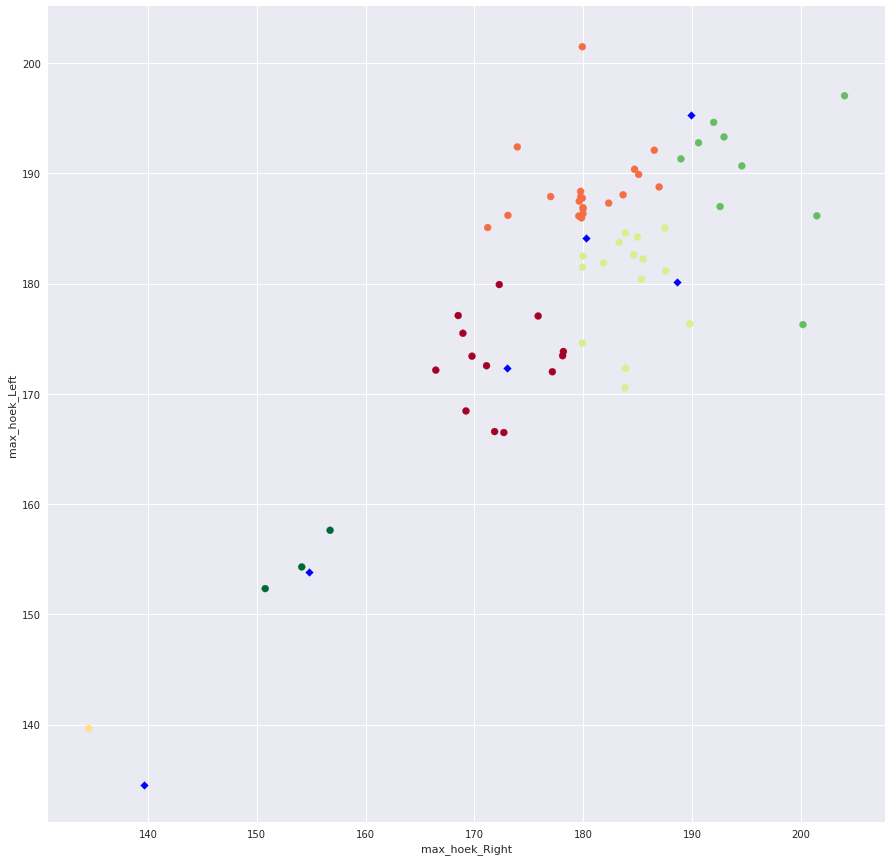

In [122]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

xs = df_max_arcs['arc_right']
ys = df_max_arcs['arc_left']
plt.xlabel("max_hoek_Right")
plt.ylabel("max_hoek_Left")
centroids = model.cluster_centers_
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]
plt.scatter(centroids_x, centroids_y, marker= 'D', s=30, color='blue')
plt.scatter(xs, ys , alpha=1, c=labels, cmap=plt.cm.RdYlGn)
plt.show()

In [123]:
import math

counter=1
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []

for i in labels:
    if i == 0:
        cluster1 = cluster1+ [counter]
    elif i== 1:
        cluster2= cluster2 + [counter]
    elif i== 2:
        cluster3= cluster3 + [counter]
    elif i== 3:
        cluster4= cluster4 + [counter]
    elif i== 4:
        cluster5= cluster5 + [counter]
    elif i== 5:
        cluster6= cluster6 + [counter]
    counter=counter+1
        
print ('cluster1', cluster1)
print ('cluster2', cluster2)
print ('cluster3', cluster3)
print ('cluster4', cluster4)
print ('cluster5', cluster5)
print ('cluster6', cluster6)


        
        
    

cluster1 [1, 3, 4, 8, 22, 27, 30, 33, 44, 45, 48, 54, 58]
cluster2 [5, 6, 7, 11, 15, 17, 18, 28, 29, 31, 32, 35, 40, 42, 46, 47, 52, 57, 60, 61]
cluster3 [2]
cluster4 [9, 10, 13, 16, 19, 20, 21, 34, 36, 37, 43, 50, 51, 56, 59]
cluster5 [12, 14, 23, 24, 38, 41, 49, 53, 55]
cluster6 [25, 26, 39]


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


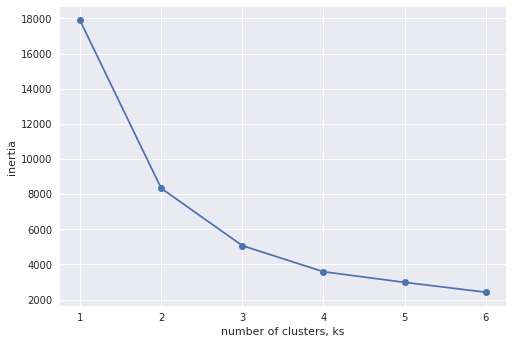

In [103]:
ks = range(1, 7)
inertias = []


for i in ks:
    model = KMeans(n_clusters = i)
    model.fit(df_max_arcs)
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, ' +'ks')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()